<a href="https://colab.research.google.com/github/Faza20-lab/Projet_stats/blob/main/Projet_stats.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import matplotlib.pyplot as plt
import xarray as xr

In [3]:
file = '/content/drive/MyDrive/data/ERA5_prec_daily_1940_2023_FR_brittany.nc'
ds = xr.open_dataset(file)

In [10]:
!pip install netCDF4

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.5/9.5 MB 92.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 79.8 MB/s eta 0:00:00


In [12]:
ds.sizes

Frozen({'Latitude': 12, 'Longitude': 14, 'time': 30449})

In [4]:
print(ds['time'])

<xarray.DataArray 'time' (time: 30449)> Size: 244kB
array(['1940-01-01T00:00:00.000000000', '1940-01-02T00:00:00.000000000',
       '1940-01-03T00:00:00.000000000', ..., '2023-05-11T00:00:00.000000000',
       '2023-05-12T00:00:00.000000000', '2023-05-13T00:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 244kB 1940-01-01 1940-01-02 ... 2023-05-13
    height   float64 8B ...


In [7]:
ds.time.values[:10]

array(['1940-01-01T00:00:00.000000000', '1940-01-02T00:00:00.000000000',
       '1940-01-03T00:00:00.000000000', '1940-01-04T00:00:00.000000000',
       '1940-01-05T00:00:00.000000000', '1940-01-06T00:00:00.000000000',
       '1940-01-07T00:00:00.000000000', '1940-01-08T00:00:00.000000000',
       '1940-01-09T00:00:00.000000000', '1940-01-10T00:00:00.000000000'],
      dtype='datetime64[ns]')

In [6]:
ds.time.values[10:]

array(['1940-01-11T00:00:00.000000000', '1940-01-12T00:00:00.000000000',
       '1940-01-13T00:00:00.000000000', ...,
       '2023-05-11T00:00:00.000000000', '2023-05-12T00:00:00.000000000',
       '2023-05-13T00:00:00.000000000'], dtype='datetime64[ns]')

In [13]:
print(ds.Latitude.values)
print(ds.Longitude.values)

[49.   48.75 48.5  48.25 48.   47.75 47.5  47.25 47.   46.75 46.5  46.25]
[-4.75 -4.5  -4.25 -4.   -3.75 -3.5  -3.25 -3.   -2.75 -2.5  -2.25 -2.
 -1.75 -1.5 ]


In [26]:
da = ds['pr'].isel(time=0)   # un jour = une carte
df = da.to_dataframe().reset_index()

In [22]:
print(df.head())

   Latitude  Longitude       time   lon   lat  height  pr
0      49.0      -4.75 1940-01-02 -4.75  49.0     0.0 NaN
1      49.0      -4.50 1940-01-02 -4.50  49.0     0.0 NaN
2      49.0      -4.25 1940-01-02 -4.25  49.0     0.0 NaN
3      49.0      -4.00 1940-01-02 -4.00  49.0     0.0 NaN
4      49.0      -3.75 1940-01-02 -3.75  49.0     0.0 NaN


In [17]:
print(da)

<xarray.DataArray 'pr' (Latitude: 12, Longitude: 14)> Size: 672B
[168 values with dtype=float32]
Coordinates:
  * Latitude   (Latitude) float64 96B 49.0 48.75 48.5 48.25 ... 46.75 46.5 46.25
  * Longitude  (Longitude) float64 112B -4.75 -4.5 -4.25 ... -2.0 -1.75 -1.5
    time       datetime64[ns] 8B 1940-01-01
    lon        (Longitude) float64 112B ...
    lat        (Latitude) float64 96B ...
    height     float64 8B ...


In [18]:
print(ds['pr'].shape)

(12, 14, 30449)


In [20]:
da = ds['pr'].isel(time=0)
print(da.shape)
print(da.values.size)

(12, 14)
168


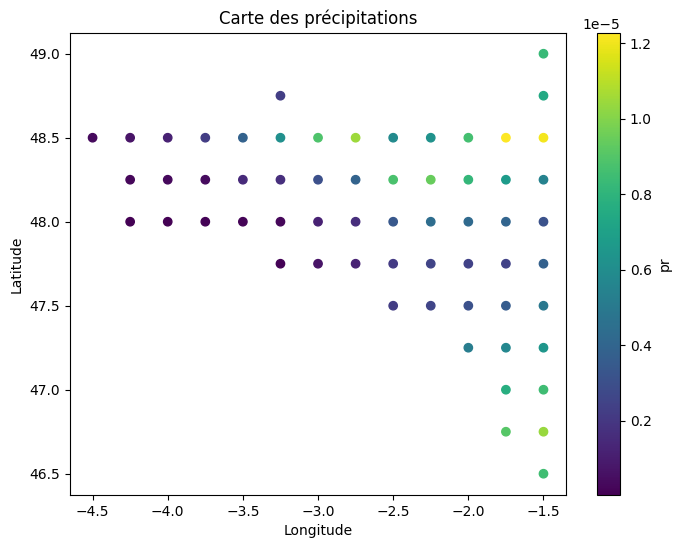

In [27]:
plt.figure(figsize=(8,6))
plt.scatter(df["Longitude"], df["Latitude"], c=df["pr"])
plt.colorbar(label="pr")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.title("Carte des précipitations")
plt.show()